# Stock Market Analysis

## Business Problem

 - A stock market investor is looking to invest in a portfolio consisting of three technology companies, three healthcare companies, as well as one cryptocurrency for the next six month period. This notebook will analyze the top ten tech and healthcare stocks according to volumne traded as well the top five cryptocurrency stocks by volume traded. The stocks will then be analyzed according to past future returns dating back to January 2016 as well as the stocks' volitility and P/E ratios over that period. A sarima model, RNN, and Facebook Prophet model will then be run on each of the stocks in order to predict future returns over the next six month period. Model results will then be compared and analyzed, and portfolio investment reccomendations will then be provided. 

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandas_datareader
import pandas_datareader.data as web
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def adfuller_of(series):
    """Prints the Augmented Dickey-Fuller test results."""
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [3]:
def get_data(stock):
    start = datetime.datetime(2016,1,1)
    end = datetime.datetime(2021,6,1)
    stock_df = web.DataReader(stock, 'yahoo', start, end)
    stock_df['Stock'] = stock
    stock_df['Returns'] = stock_df['Close'].pct_change(1)
    stock_df['Cumulative Return'] = (1 + stock_df['Returns']).cumprod()
    return stock_df

## Load Data

In [4]:
#tesla = web.DataReader('TSLA', 'yahoo', start, end)

### Top 10 Tech Stocks

In [5]:
apple = get_data('AAPL')

In [6]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1362 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               1362 non-null   float64
 1   Low                1362 non-null   float64
 2   Open               1362 non-null   float64
 3   Close              1362 non-null   float64
 4   Volume             1362 non-null   float64
 5   Adj Close          1362 non-null   float64
 6   Stock              1362 non-null   object 
 7   Returns            1361 non-null   float64
 8   Cumulative Return  1361 non-null   float64
dtypes: float64(8), object(1)
memory usage: 106.4+ KB


In [7]:
microsoft = get_data('MSFT')

In [8]:
google = get_data('GOOG')

In [9]:
amazon = get_data('AMZN')

In [10]:
facebook = get_data('FB')

In [11]:
tencent = get_data('TCEHY')

In [12]:
alibaba = get_data('BABA')

In [13]:
tesla = get_data('TSLA')

In [14]:
tsmc = get_data('TSM')

In [15]:
nvidia = get_data('NVDA')

In [16]:
to_concat = [apple, microsoft, google, amazon, facebook, tencent, alibaba, tesla, tsmc, nvidia]
tech_df = pd.concat(to_concat)

In [17]:
tech_df.shape

(13620, 9)

In [18]:
tech_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13620 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               13620 non-null  float64
 1   Low                13620 non-null  float64
 2   Open               13620 non-null  float64
 3   Close              13620 non-null  float64
 4   Volume             13620 non-null  float64
 5   Adj Close          13620 non-null  float64
 6   Stock              13620 non-null  object 
 7   Returns            13610 non-null  float64
 8   Cumulative Return  13610 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


In [19]:
aapl_df = tech_df[tech_df['Stock'] == 'AAPL']
aapl_df.shape

(1362, 9)

In [20]:
aapl_df.iloc[-1]

High                      125.35
Low                       123.94
Open                      125.08
Close                     124.28
Volume               6.76371e+07
Adj Close                 124.28
Stock                       AAPL
Returns              -0.00264828
Cumulative Return        4.71875
Name: 2021-06-01 00:00:00, dtype: object

In [21]:
msft_df = tech_df[tech_df['Stock'] == 'MSFT']
msft_df.shape

(1362, 9)

### Top 10 Healthcare Stocks

In [22]:
united_health = get_data('UNH')

In [23]:
cvs = get_data('CVS')

In [24]:
hca = get_data('HCA')

In [25]:
mckesson = get_data('MCK')

In [26]:
amerisource_bergen = get_data('ABC')

In [27]:
cerner = get_data('CERN')

In [28]:
teladoc_health = get_data('TDOC')

In [29]:
bio_rad = get_data('BIO')

In [30]:
cardinal_health = get_data('CAH')

In [31]:
perkin_elmer = get_data('PKI')

In [32]:
to_concat = [united_health, cvs, hca, mckesson, amerisource_bergen, cerner, teladoc_health,
            bio_rad, cardinal_health, perkin_elmer]
healthcare_df = pd.concat(to_concat)

In [33]:
healthcare_df.shape

(13620, 9)

In [34]:
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13620 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               13620 non-null  float64
 1   Low                13620 non-null  float64
 2   Open               13620 non-null  float64
 3   Close              13620 non-null  float64
 4   Volume             13620 non-null  float64
 5   Adj Close          13620 non-null  float64
 6   Stock              13620 non-null  object 
 7   Returns            13610 non-null  float64
 8   Cumulative Return  13610 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


### Top 5 Cryptocurrency Stocks

In [35]:
bitcoin = get_data('BTC-USD')

In [36]:
ethereum = get_data('ETH-USD')

In [37]:
#binance_coin = get_data('BNB-USD')

In [38]:
#cardano = get_data('ADA-USD')

In [39]:
dogecoin = get_data('DOGE-USD')

In [40]:
xrp = get_data('XRP-USD')

In [41]:
litecoin = get_data('LTC-USD')

In [42]:
#stellar = get_data('XLM-USD')

In [43]:
to_concat = [bitcoin, ethereum, dogecoin, xrp, litecoin]
crypto_df = pd.concat(to_concat)

In [44]:
crypto_df.shape

(9880, 9)

In [45]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9880 entries, 2016-01-01 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               9880 non-null   float64
 1   Low                9880 non-null   float64
 2   Open               9880 non-null   float64
 3   Close              9880 non-null   float64
 4   Volume             9880 non-null   float64
 5   Adj Close          9880 non-null   float64
 6   Stock              9880 non-null   object 
 7   Returns            9875 non-null   float64
 8   Cumulative Return  9875 non-null   float64
dtypes: float64(8), object(1)
memory usage: 771.9+ KB


## Data Exploration

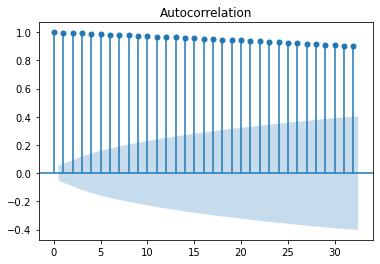

In [46]:
plot_acf(apple['Close']);

In [47]:
decomposition = seasonal_decompose(apple['Close'], period=365)

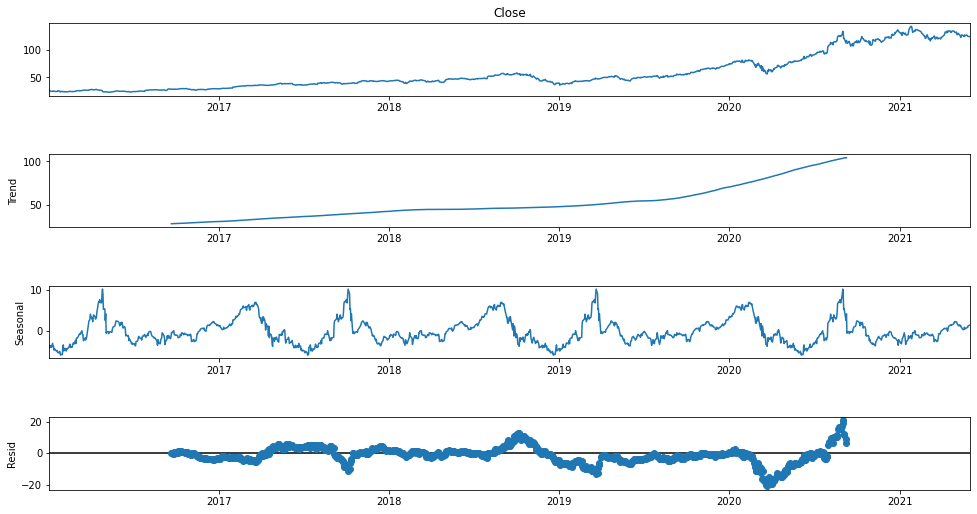

In [48]:
fig = decomposition.plot()
fig.set_size_inches(15,8)

In [49]:
#tesla['Cumulative Return'] = (1 + tesla['Returns']).cumprod()

In [50]:
tech_df.head()

,High,Low,Open,Close,Volume,Adj Close,Stock,Returns,Cumulative Return
Date,,,,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.323219,AAPL,NaN,NaN
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.713696,AAPL,-0.025059,0.974941
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.249626,AAPL,-0.019570,0.955861
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.268383,AAPL,-0.042205,0.915520
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.386133,AAPL,0.005288,0.920361


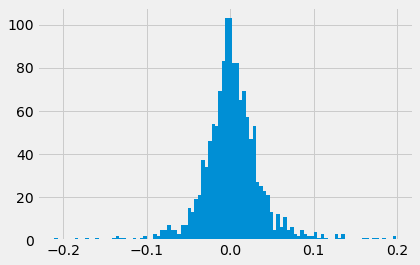

In [51]:
plt.style.use('fivethirtyeight')
tesla['Returns'].hist(bins=100);

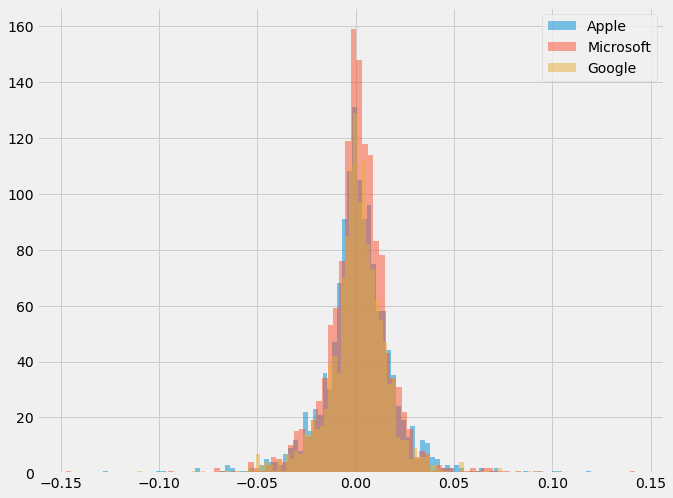

In [52]:
apple['Returns'].hist(bins=100, label='Apple', figsize=(10,8), alpha=0.5)
microsoft['Returns'].hist(bins=100, label='Microsoft', figsize=(10,8), alpha=0.5)
google['Returns'].hist(bins=100, label='Google', figsize=(10,8), alpha=0.5)
plt.legend();

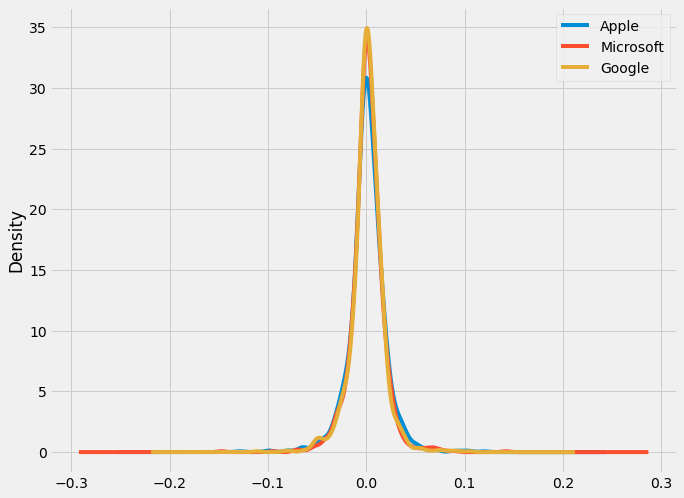

In [53]:
apple['Returns'].plot(kind='kde', label='Apple', figsize=(10,8))
microsoft['Returns'].plot(kind='kde', label='Microsoft', figsize=(10,8))
google['Returns'].plot(kind='kde', label='Google', figsize=(10,8))
plt.legend();

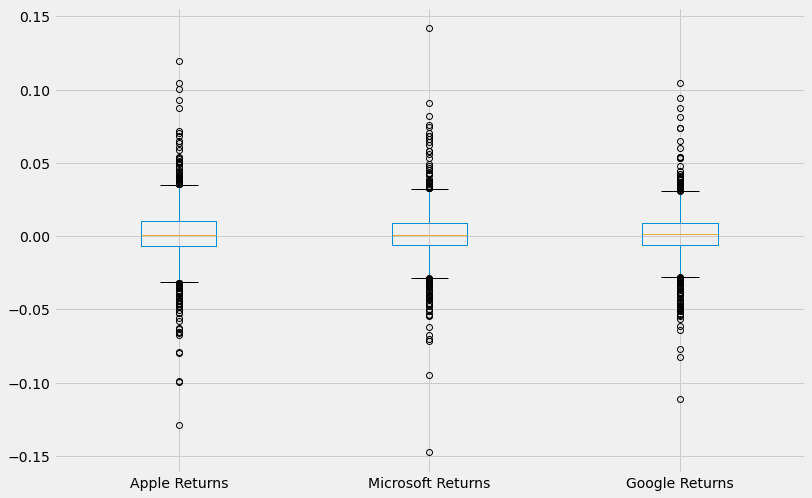

In [54]:
box_df = pd.concat([apple['Returns'], microsoft['Returns'], google['Returns']], axis=1)
box_df.columns = ['Apple Returns', 'Microsoft Returns', 'Google Returns']
box_df.plot(kind='box', figsize=(12,8));

In [55]:
tesla.tail()

,High,Low,Open,Close,Volume,Adj Close,Stock,Returns,Cumulative Return
Date,,,,,,,,,
2021-05-25,613.989990,595.710022,607.309998,604.690002,28005900.0,604.690002,TSLA,-0.002886,13.533190
2021-05-26,626.169983,601.500000,607.559998,619.130005,28639300.0,619.130005,TSLA,0.023880,13.856363
2021-05-27,631.130005,616.210022,620.239990,630.849976,26370600.0,630.849976,TSLA,0.018930,14.118660
2021-05-28,635.590027,622.380005,628.500000,625.219971,22737000.0,625.219971,TSLA,-0.008924,13.992659
2021-06-01,633.799988,620.549988,627.799988,623.900024,18084900.0,623.900024,TSLA,-0.002111,13.963118


In [56]:
#tesla.iloc[-1,-1]

In [57]:
def returns_dict(df):
    """Takes in a"""
    returns_lst = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        ret = stock_df.iloc[-1,8]
        returns_lst.append(round(ret,2)) 
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
    
    returns_dict = dict(zip(stock_names, returns_lst))
    return(returns_dict)

In [58]:
returns_dict(tech_df)

{'AAPL': 4.72,
 'MSFT': 4.51,
 'GOOG': 3.28,
 'AMZN': 5.05,
 'FB': 3.22,
 'TCEHY': 4.25,
 'BABA': 2.86,
 'TSLA': 13.96,
 'TSM': 5.36,
 'NVDA': 20.1}

In [59]:
returns_dict(crypto_df)

{'BTC-USD': 86.51,
 'ETH-USD': 2854.49,
 'DOGE-USD': 2749.18,
 'XRP-USD': 172.02,
 'LTC-USD': 53.37}

In [60]:
health_returns = returns_dict(healthcare_df)

In [61]:
health_df = pd.DataFrame(list(health_returns.items()),columns = ['Stock','Cumulative Return']) 
health_df.sort_values(by='Cumulative Return', ascending=False).reset_index(drop=True)

,Stock,Cumulative Return
0,TDOC,8.47
1,BIO,4.27
2,UNH,3.49
3,HCA,3.26
4,PKI,2.70
5,CERN,1.34
6,ABC,1.12
7,MCK,0.99
8,CVS,0.89
9,CAH,0.63


Text(0.5, 0, 'Cumulative Return %')

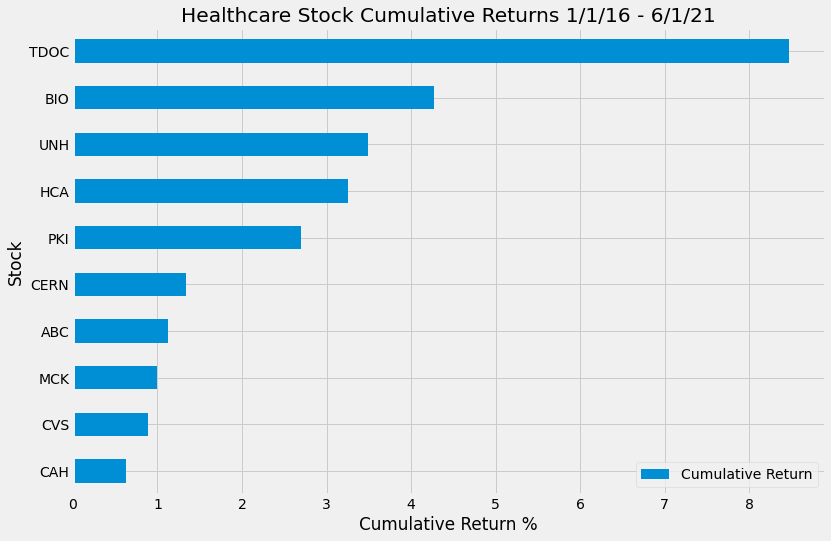

In [62]:
ax = health_df.sort_values('Cumulative Return').plot.barh(x='Stock', figsize=(12,8))
plt.title('Healthcare Stock Cumulative Returns 1/1/16 - 6/1/21')
plt.xlabel('Cumulative Return %')

In [63]:
def get_roi_dict(df):
    """Takes in a"""
    roi_lst = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        #resampled_df = county_df.resample(rule='A').mean()
        cost = stock_df.iloc[0,3]
        value = stock_df.iloc[-1,3]
        ROI = (value-cost)/cost
        roi_lst.append(round(ROI,2))
    stock_names = []
    for n in tech_df.Stock.unique():
        stock_names.append(n)
        
    roi_dict = dict(zip(roi_lst, stock_names))
    return(roi_dict)

In [64]:
get_roi_dict(tech_df)

{3.72: 'AAPL',
 3.51: 'MSFT',
 2.28: 'GOOG',
 4.05: 'AMZN',
 2.22: 'FB',
 3.25: 'TCEHY',
 1.86: 'BABA',
 12.96: 'TSLA',
 4.36: 'TSM',
 19.1: 'NVDA'}

## Modeling

### SARIMA Models

In [65]:
tech_df.shape

(13620, 9)

In [66]:
def sarima_model_fcast(df):
    """Takes in a dataframe, runs a stepwise fit and SARIMA model on each stock and returns a dictionary of."""
    forcasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        #monthly_df = county_df.resample(rule='M').mean()
        stepwise_fit = auto_arima(stock_df['Close'])
        model_order = stepwise_fit.order
        train = stock_df.iloc[:997]
        test = stock_df.iloc[997:]
        model = SARIMAX(train['Close'], order=model_order)
        results = model.fit()
        start = len(train)
        end = len(train) + len(test) - 1
        predictions = results.predict(start, end, typ='levels')
        error = rmse(test['Close'], predictions)
        future_model = SARIMAX(stock_df['Close'], order=model_order)
        results_future = future_model.fit()
        fcast = results_future.predict(len(stock_df), len(stock_df)+183, typ='levels')
        fcast_df = pd.DataFrame(fcast)
        #cost = fcast_df.iloc[0,0]
        #value = fcast_df.iloc[-1,0]
        #ROI = (value-cost)/cost
        ret = fcast_df.iloc[-1,-1]
        forcasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forcasted_returns))
    
    return returns_dict

In [67]:
#sarima_model_fcast(tech_df)

In [68]:
apple.shape

(1362, 9)

In [69]:
resampled = apple.resample(rule='M').mean()

In [70]:
stepwise_fit = auto_arima(apple['Close'])
model_order = stepwise_fit.order
model_order

(2, 1, 3)

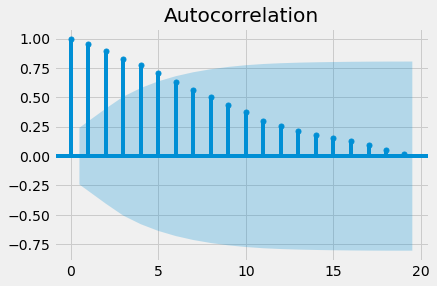

In [71]:
plot_acf(resampled['Close']);

In [72]:
resampled.shape

(66, 8)

In [73]:
train = resampled.iloc[:54]

In [74]:
test = resampled.iloc[54:]

In [75]:
model = SARIMAX(train['Close'], order=model_order)

In [76]:
results = model.fit()

In [77]:
start = len(train)

In [78]:
end = len(train) + len(test) - 1

In [79]:
predictions = results.predict(start=start, end=end, typ='levels').rename('SARIMA Predictions')
print(predictions)

2020-07-31    89.822095
2020-08-31    89.259914
2020-09-30    86.999794
2020-10-31    84.382392
2020-11-30    82.856909
2020-12-31    83.184438
2021-01-31    85.067449
2021-02-28    87.379928
2021-03-31    88.834191
2021-04-30    88.692938
2021-05-31    87.135652
2021-06-30    85.101895
Freq: M, Name: SARIMA Predictions, dtype: float64


<AxesSubplot:xlabel='Date'>

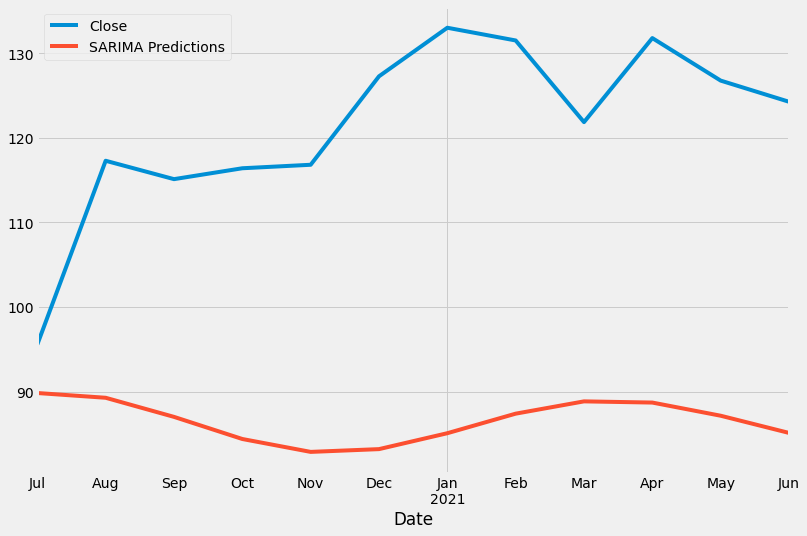

In [80]:
test['Close'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True)

In [81]:
error = rmse(test['Close'], predictions)

In [82]:
test['Close'].mean()

121.48645553530388

In [83]:
error

36.5645602523666

In [84]:
model_2 = SARIMAX(resampled['Close'], order=model_order)
results_2 = model_2.fit()

In [85]:
fcast_2 = results_2.predict(len(resampled), len(resampled)+11, typ='levels').rename('SARIMA Forecast')

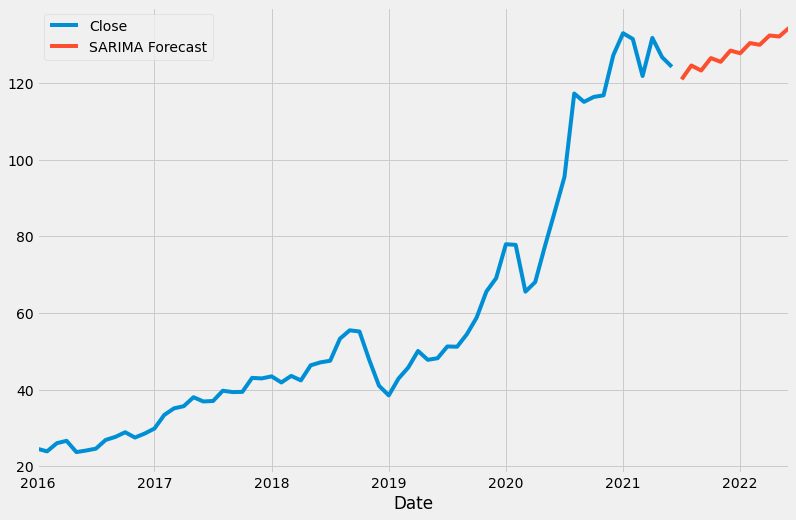

In [86]:
resampled['Close'].plot(legend=True, figsize=(12,8))
fcast_2.plot(legend=True);

### SARIMA Model B

In [157]:
stepwise_fit = auto_arima(train_b)
stepwise_fit.summary()
model_order = stepwise_fit.order

In [158]:
model_order

(2, 1, 2)

In [88]:
apple.shape

(1362, 9)

In [139]:
train_b = (
    apple
    .iloc[:997]['Close']
    .resample('D')
    .mean()
    .ffill()
)

In [141]:
test_b = (
    apple
    .iloc[997:]['Close']
    .resample('D')
    .mean()
    .ffill()
)

In [140]:
train_b

Date
2016-01-04    26.337500
2016-01-05    25.677500
2016-01-06    25.174999
2016-01-07    24.112499
2016-01-08    24.240000
                ...    
2019-12-13    68.787498
2019-12-14    68.787498
2019-12-15    68.787498
2019-12-16    69.964996
2019-12-17    70.102501
Freq: D, Name: Close, Length: 1444, dtype: float64

In [162]:
model_b = ARIMA(train_b, order=(2,2,2))

In [163]:
results_b = model_b.fit()

In [164]:
start_b = train_b.index.min()
end_b = train_b.index.max()

In [165]:
test_start_b = test_b.index.min()
test_end_b = test_b.index.max()

In [166]:
predictions_b = results_b.predict(start=start_b, end=end_b, typ='levels').rename('SARIMA Predictions')
print(predictions_b)

KeyError: Timestamp('2016-01-04 00:00:00', freq='D')

In [150]:
test_predictions_b = results_b.predict(start=test_start_b, end=test_end_b, typ='levels').rename('SARIMA Predictions')
print(test_predictions_b)

2019-12-18    70.062175
2019-12-19    70.125046
2019-12-20    70.137297
2019-12-21    70.081122
2019-12-22    70.094013
                ...    
2021-05-28    70.107516
2021-05-29    70.107516
2021-05-30    70.107516
2021-05-31    70.107516
2021-06-01    70.107516
Freq: D, Name: SARIMA Predictions, Length: 532, dtype: float64


<AxesSubplot:xlabel='Date'>

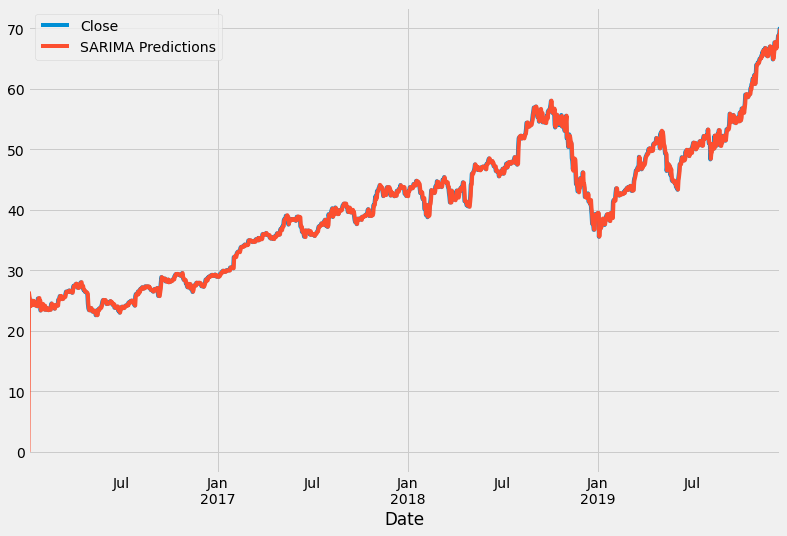

In [146]:
train_b.plot(legend=True, figsize=(12,8))
predictions_b.plot(legend=True)

<AxesSubplot:xlabel='Date'>

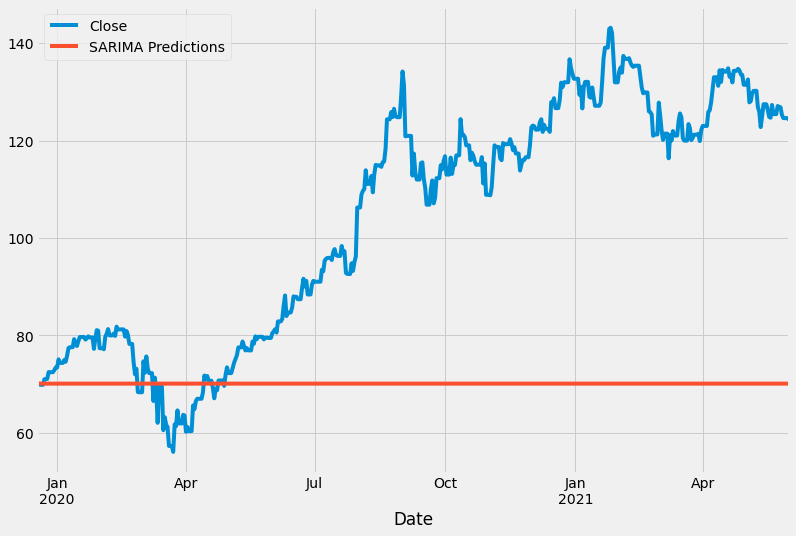

In [152]:
test_b.plot(legend=True, figsize=(12,8))
test_predictions_b.plot(legend=True)

### RNN Models

In [95]:
resampled.shape

(66, 8)

In [96]:
train.shape

(54, 8)

In [97]:
test.shape

(12, 8)

In [98]:
scaler = MinMaxScaler()

In [99]:
scaler.fit(train[['Close']])

MinMaxScaler()

In [100]:
scaled_train = scaler.transform(train[['Close']])
scaled_test = scaler.transform(test[['Close']])

In [101]:
n_input = 2
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [102]:
len(scaled_train)

54

In [103]:
scaled_train[:5]

array([[0.01377093],
       [0.00307672],
       [0.03704681],
       [0.04690113],
       [0.        ]])

In [104]:
X,y = generator[0]

In [105]:
X

array([[[0.01377093],
        [0.00307672]]])

In [106]:
y

array([[0.03704681]])

In [107]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [168]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [169]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 150)           91200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 147,297
Trainable params: 147,297
Non-trainable params: 0
_________________________________________________________________


In [170]:
model.fit_generator(train_generator, epochs=20)

Epoch 1/20
42/42 [==============================] - 1s 35ms/step - loss: 0.0525
Epoch 2/20
42/42 [==============================] - 1s 33ms/step - loss: 0.0235
Epoch 3/20
42/42 [==============================] - 1s 31ms/step - loss: 0.0205: 0
Epoch 4/20
42/42 [==============================] - 1s 33ms/step - loss: 0.0257
Epoch 5/20
42/42 [==============================] - 1s 29ms/step - loss: 0.0175
Epoch 6/20
42/42 [==============================] - 1s 35ms/step - loss: 0.0230
Epoch 7/20
42/42 [==============================] - 1s 28ms/step - loss: 0.0228
Epoch 8/20
42/42 [==============================] - 1s 36ms/step - loss: 0.0151
Epoch 9/20
42/42 [==============================] - 1s 33ms/step - loss: 0.0139
Epoch 10/20
42/42 [==============================] - 2s 38ms/step - loss: 0.0149
Epoch 11/20
42/42 [==============================] - 2s 36ms/step - loss: 0.0133
Epoch 12/20
42/42 [==============================] - 2s 36ms/step - loss: 0.0179
Epoch 13/20
42/42 [===============

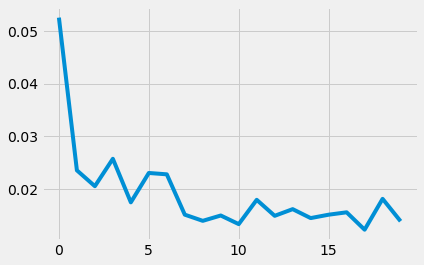

In [171]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [172]:
first_eval_batch = scaled_train[-12:]

In [173]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [174]:
model.predict(first_eval_batch)

array([[0.9472993]], dtype=float32)

### RNN Forecast

In [175]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [176]:
test_predictions

[array([0.9472993], dtype=float32),
 array([1.0132489], dtype=float32),
 array([1.086398], dtype=float32),
 array([1.1680515], dtype=float32),
 array([1.2615387], dtype=float32),
 array([1.3669575], dtype=float32),
 array([1.492676], dtype=float32),
 array([1.6400969], dtype=float32),
 array([1.8299314], dtype=float32),
 array([2.0930254], dtype=float32),
 array([2.4439914], dtype=float32),
 array([2.9325209], dtype=float32)]

In [177]:
true_predictions = scaler.inverse_transform(test_predictions)

In [178]:
true_predictions

array([[ 83.14684   ],
       [ 87.28240208],
       [ 91.86942757],
       [ 96.98974554],
       [102.85213543],
       [109.46272705],
       [117.34626853],
       [126.59072249],
       [138.49484374],
       [154.99292014],
       [177.00125941],
       [207.63591477]])

In [179]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='Date'>

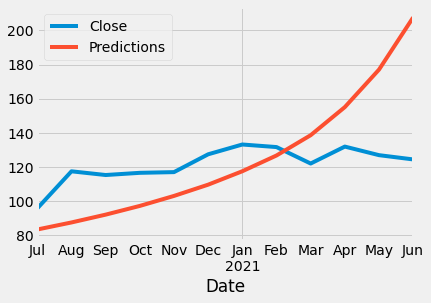

In [180]:
test['Close'].plot(legend=True)
test['Predictions'].plot(legend=True)

### RNN Model B 

In [121]:
apple.shape

(1362, 9)

In [122]:
aapl_train = apple.iloc[:997]
aapl_test = apple.iloc[997:]

In [123]:
scaler_b = MinMaxScaler()
scaler_b.fit(aapl_train[['Close']])

MinMaxScaler()

In [124]:
scaled_train_a = scaler_b.transform(aapl_train[['Close']])
scaled_test_a = scaler_b.transform(aapl_test[['Close']])

In [125]:
n_input_b = 365
n_features_b = 1

generator = TimeseriesGenerator(scaled_train_a, scaled_train_a, length=n_input, batch_size=1)

In [126]:
model_b = Sequential()

model_b.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_b.add(Dense(1))
model_b.compile(optimizer='adam', loss='mse')

In [127]:
model_b.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [128]:
model_b.fit_generator(train_generator, epochs=30)

Epoch 1/30
42/42 [==============================] - 0s 8ms/step - loss: 0.0638
Epoch 2/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 3/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 4/30
42/42 [==============================] - 0s 8ms/step - loss: 0.0116
Epoch 5/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0142
Epoch 6/30
42/42 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 7/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 8/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 9/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0141
Epoch 10/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0101
Epoch 11/30
42/42 [==============================] - 0s 8ms/step - loss: 0.0095
Epoch 12/30
42/42 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 13/30
42/42 [=============================

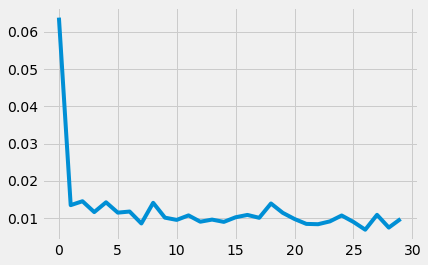

In [129]:
plt.plot(range(len(model_b.history.history['loss'])), model_b.history.history['loss'])

In [130]:
test_predictions_b = []
first_eval_batch_b = scaled_train_a[-n_input_b:]
current_batch_b = first_eval_batch_b.reshape((1, n_input_b, n_features_b))

for i in range(len(aapl_test)):
    
    current_pred_b = model_b.predict(current_batch_b)[0]
    
    test_predictions_b.append(current_pred_b)
    
    current_batch_b = np.append(current_batch_b[:,1:,:], [[current_pred_b]], axis=1)

In [131]:
true_predictions_b = scaler_b.inverse_transform(test_predictions_b)

ValueError: Input contains infinity or a value too large for dtype('float64').

### Facebook Prophet Model

In [ ]:
from fbprophet import Prophet

In [ ]:
apple_close = pd.DataFrame(apple['Close'])
apple_close.reset_index(inplace=True)

In [ ]:
apple_close.columns = ['ds', 'y']
apple_close.head()

In [ ]:
apple_close['ds'] = pd.to_datetime(apple_close['ds'])

In [ ]:
apple_close.info()

In [ ]:
apple_close.shape

In [ ]:
train_c = apple_close[:997]
test_c = apple_close[997:]

In [ ]:
test_c.shape

In [ ]:
apple_close[:997]

In [ ]:
m = Prophet()
m.fit(train_c)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

In [ ]:
forecast.shape

In [ ]:
forecast.tail()

In [ ]:
test_c

In [ ]:
ax = forecast.plot(x='ds', y ='yhat', label='Predictions', legend=True, figsize=(12,8))
test_c.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax, xlim=('2019-12-18', '2021-06-01'))

In [ ]:
rmse(forecast, test_c['y'])

In [ ]:
forecast.columns

In [ ]:
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']].tail()

In [ ]:
m.plot(forecast);

In [ ]:
m.plot_components(forecast);